In [2]:
import mib as mb1
import mib_v2_1 as mb
import matplotlib.pyplot as plt
import time
from itertools import product
import tracemalloc

# Test 1

## Planteamiento
Comparar rendimiento del mib1.0 contra el mib2.0 con problema pequeño y con tres eventon con distribuciones uniformes.
Se hara el test 100 veces y en cada iteración la cardinalidad de las tres variables crecera en 1, iniciando por cardinalidad de uno.

### Variables
A = \{0, 2, ..., n-1\}

B = \{0, 2, ..., n-1\}

C = \{0, 2, ..., n-1\}

### Modelo de descomposición
$P(ABC) = P(A)P(B|A)P(C|AB)$.

$\;\;\;\;\;\;\;\;\;\;\;\;$<img src="./P(ABC).jpg" width=200/>

### Formas
$P(A)$, $P(B|A)$ y $P(C|AB)$ serán distribuciones uniformes.

### MIB1.0

In [12]:
n = 30
timesM1 = []
memoryM1 = []

timesC1 = []
memoryC1 = []

for i in range(n):
    Events = [x for x in range(i+1)]
    # Varaibles
    A = mb1.Var('A',Events)
    B = mb1.Var('B',Events)
    C = mb1.Var('C',Events)

    dA = {}
    dB_A = {}
    dC_AB = []
    value = 1 / (i+1)
    for e in Events:
        dA[e] = value
        dB_A[e] = {}
        for e1 in Events:
            dB_A[e][e1] = value
            tC_AB = []
            for e2 in Events:
                tC_AB.append(value)
            dC_AB.append(tuple(tC_AB))
    
    PA=mb1.Distrib(name='P(A)',variable=[A],tabla=dA)
    PB_A=mb1.DistribCond(name='P(B|A)',var=B,indep=[A],tabla=dB_A)
    PC_AB=mb1.DistribCond('P(C|AB)',C,[A,B],dC_AB)
    
    PABC=mb1.JointDistrib(name='P(ABC)',variables=[A,B,C],descomp=[PA,PB_A,PC_AB])
    Q_ABC=mb1.Question(joint=PABC)

    #Inferencia de P(B)
    tracemalloc.start()
    
    inicio = time.time()
    PB = Q_ABC.query(searched=[B])
    fin = time.time()
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesM1.append(tiempo_ejecucion)
    memoryM1.append(memoria_pico)
    
    #Inferencia de P(A|BC)
    tracemalloc.start()
    
    inicio = time.time()
    PA_BC = Q_ABC.query(searched=[A], known=[B,C])
    fin = time.time() 
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesC1.append(tiempo_ejecucion)
    memoryC1.append(memoria_pico)

KeyboardInterrupt: 

In [15]:
print(len(timesC1), len(timesM1), len(memoryM1), len(memoryC1))

19 20 20 19


In [24]:
timesM1_aux = timesM1[:19]
memoryM1_aux = memoryM1[:19]

In [25]:
print(len(timesC1), len(timesM1_aux), len(memoryM1_aux), len(memoryC1))

19 19 19 19


### MIB2.0

In [34]:
n = 19
timesM = []
memoryM = []
timesC = []
memoryC = []


for i in range(n):
    Events = set([x for x in range(i+1)])
        
    # Generación de distribuciones de probabilidad (Distribuciones uniformes).
    dA = {}
    dB_A = {}
    dC_AB = {}
    value = 1 / (i+1)
    for x in range(i+1):
        dA[(x,)] = value
        dB_A[(x,)] = {}
        for y in range(i+1):
            dB_A[(x,)][(y,)] = value
            dC_AB[(x,y)] = {}
            for z in range(i+1):
                dC_AB[(x,y)][(z,)] = value
        
    # Variables para el motor de inferencia.
    A = mb.Var(Events)
    PA = mb.Distrib(set([A]),dA)
    B = mb.Var(Events)
    PB_A = mb.CondDistrib(set([B]),set([A]),dB_A)
    C = mb.Var(Events)
    PC_AB = mb.CondDistrib(set([C]),set([A,B]),dC_AB)
        
    # Probabilidad conjunta (especificación).
    PABC = mb.Specification(set([A,B,C]), set([PA,PB_A,PC_AB]))
        
    # Pregunta para hacer las consultas sobre P(ABC).
    Q_ABC = mb.Question(PABC)
        
    #Inferencia de P(B)
    tracemalloc.start()
    
    inicio = time.time()
    PB = Q_ABC.DistributionQuery(set([B])) 
    fin = time.time()
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesM.append(tiempo_ejecucion)
    memoryM.append(memoria_pico)
    
    #Inferencia de P(A|BC)
    tracemalloc.start()
    
    inicio = time.time()
    PA_BC = Q_ABC.DistributionQuery(set([A]), set([B,C]))
    fin = time.time() 
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesC.append(tiempo_ejecucion)
    memoryC.append(memoria_pico)    

In [27]:
xn = [i+1 for i in range(n)]

### Tiempo de la inferencia en P(B)

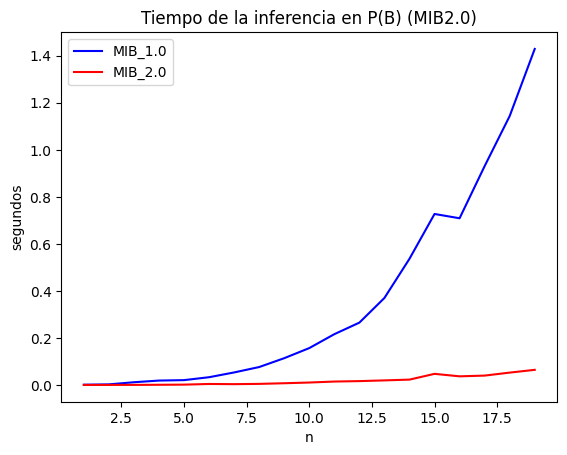

In [29]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, timesM1_aux, color='b', label = 'MIB_1.0')
ax.set_title("Tiempo de la inferencia en P(B) (MIB1.0)")

# MIB_2.0
ax.plot(xn, timesM, color='r',label = 'MIB_2.0')
ax.set_title("Tiempo de la inferencia en P(B) (MIB2.0)")

ax.set_xlabel("n")
ax.set_ylabel("segundos")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

### Memoria de la inferencia en P(B)

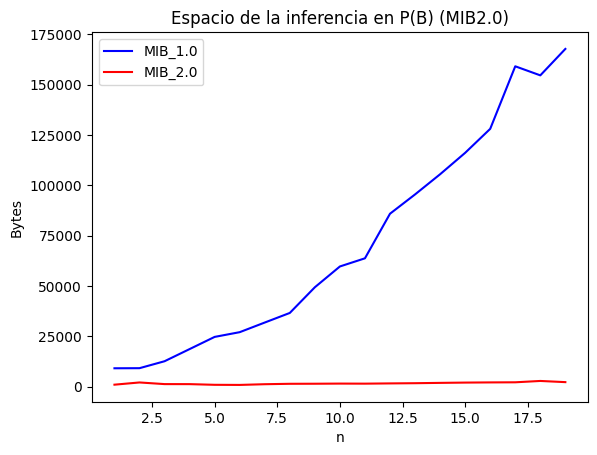

In [35]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, memoryM1_aux, color='b', label = 'MIB_1.0')
ax.set_title("Espacio de la inferencia en P(B) (MIB1.0)")

# MIB_2.0
ax.plot(xn, memoryM, color='r',label = 'MIB_2.0')
ax.set_title("Espacio de la inferencia en P(B) (MIB2.0)")

ax.set_xlabel("n")
ax.set_ylabel("Bytes")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

### Tiempo de la inferencia de P(A|BC)

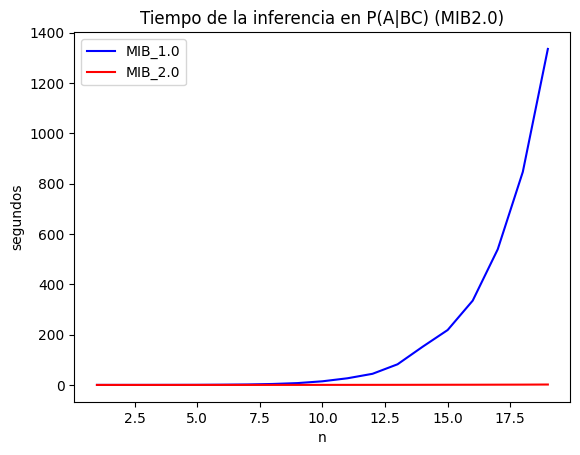

In [31]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, timesC1, color='b', label = 'MIB_1.0')
ax.set_title("Tiempo de la inferencia en P(A|BC) (MIB1.0)")

# MIB_2.0
ax.plot(xn, timesC, color='r',label = 'MIB_2.0')
ax.set_title("Tiempo de la inferencia en P(A|BC) (MIB2.0)")

ax.set_xlabel("n")
ax.set_ylabel("segundos")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

### Memoria de la inferencia en P(A|BC)

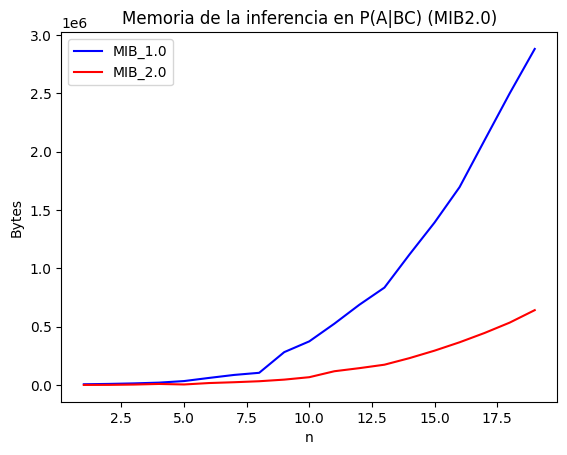

In [36]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, memoryC1, color='b', label = 'MIB_1.0')
ax.set_title("Memoria de la inferencia en P(A|BC) (MIB1.0)")

# MIB_2.0
ax.plot(xn, memoryC, color='r',label = 'MIB_2.0')
ax.set_title("Memoria de la inferencia en P(A|BC) (MIB2.0)")

ax.set_xlabel("n")
ax.set_ylabel("Bytes")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()